### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context='paper', color_codes=False)

sys.path.insert(0,"../")
from plotGraphs import *
from MLpipelines.plotResults import *
from imagen_dataloader import *
# from niwidgets import NiftiWidget

In [4]:
# Specify the path to the data
DATA_DIR = "/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/"
BIDS_DIR = "/ritter/share/data/IMAGEN/IMAGEN_BIDS/"

In [5]:
# path to questionaires files
qs = dict(
        AUDIT_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_AUDIT_CHILD_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU2-IMAGEN_DIGEST.csv",
        AUDIT_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv",
        ESPAD_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU2-IMAGEN_DIGEST.csv",
        ESPAD_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv",
          
        AUDIT_GM       = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM.csv",
        AUDIT_GM_FINE  = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM_FINE.csv",
        ESPAD_GM       = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM.csv",
        ESPAD_GM_FINE  = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM_FINE.csv",
        
        PHENOTYPE = DATA_DIR + "combinations/drinking_phenotype/Seo_drinking_phenotype_fu2.csv",
        )

### Plots

#### Random confounds

In [9]:
from matplotlib.lines import Line2D


def plot_dists(df_ccs, df_true, sharey=True):

    fig, axes = plt.subplots(len(df_ccs), 4, sharex=True, sharey=sharey, figsize=(16,4*len(df_ccs)))

    for i, df_cc_path in enumerate(df_ccs):
        df_cc = pd.read_csv(glob(df_cc_path)[-1])
        axes_row = axes[i]    
        # draw legend
        custom_lines = [Line2D([0], [0], color="tab:blue", markerfacecolor="tab:blue", marker='o', markersize=5, lw=0),
                        Line2D([0], [0], color="tab:red", lw=1, linestyle="--")]

        axes_row[0].legend(custom_lines, ['conf permuted score', 'model score'], loc='upper left')
        ylabel = "confounds ="
        ylabel += df_cc_path.split("permuteconfs-")[-1][:2] + ' random'
        if 'excludingsexsite' not in df_cc_path: ylabel += '+ [sex, site]'
        axes_row[0].set_ylabel(ylabel)

        for j, (model, dfi) in enumerate(df_cc.groupby('model')):
            ax = axes_row[j]
            ax.hist(dfi['test_score'], bins='auto', alpha=0.8)
            for true_score in df_true.loc[df_true.model == model, 'test_score']:
                ax.axvline(true_score, color="tab:red", lw=1, linestyle="--")

            if i==0: ax.set_title(f"model = {model}")

            # chance line
            ax.axvline(0.5, color="k", lw=1)

            if i==len(df_ccs)-1: ax.set_xlabel("Balanced accuracy (%)")

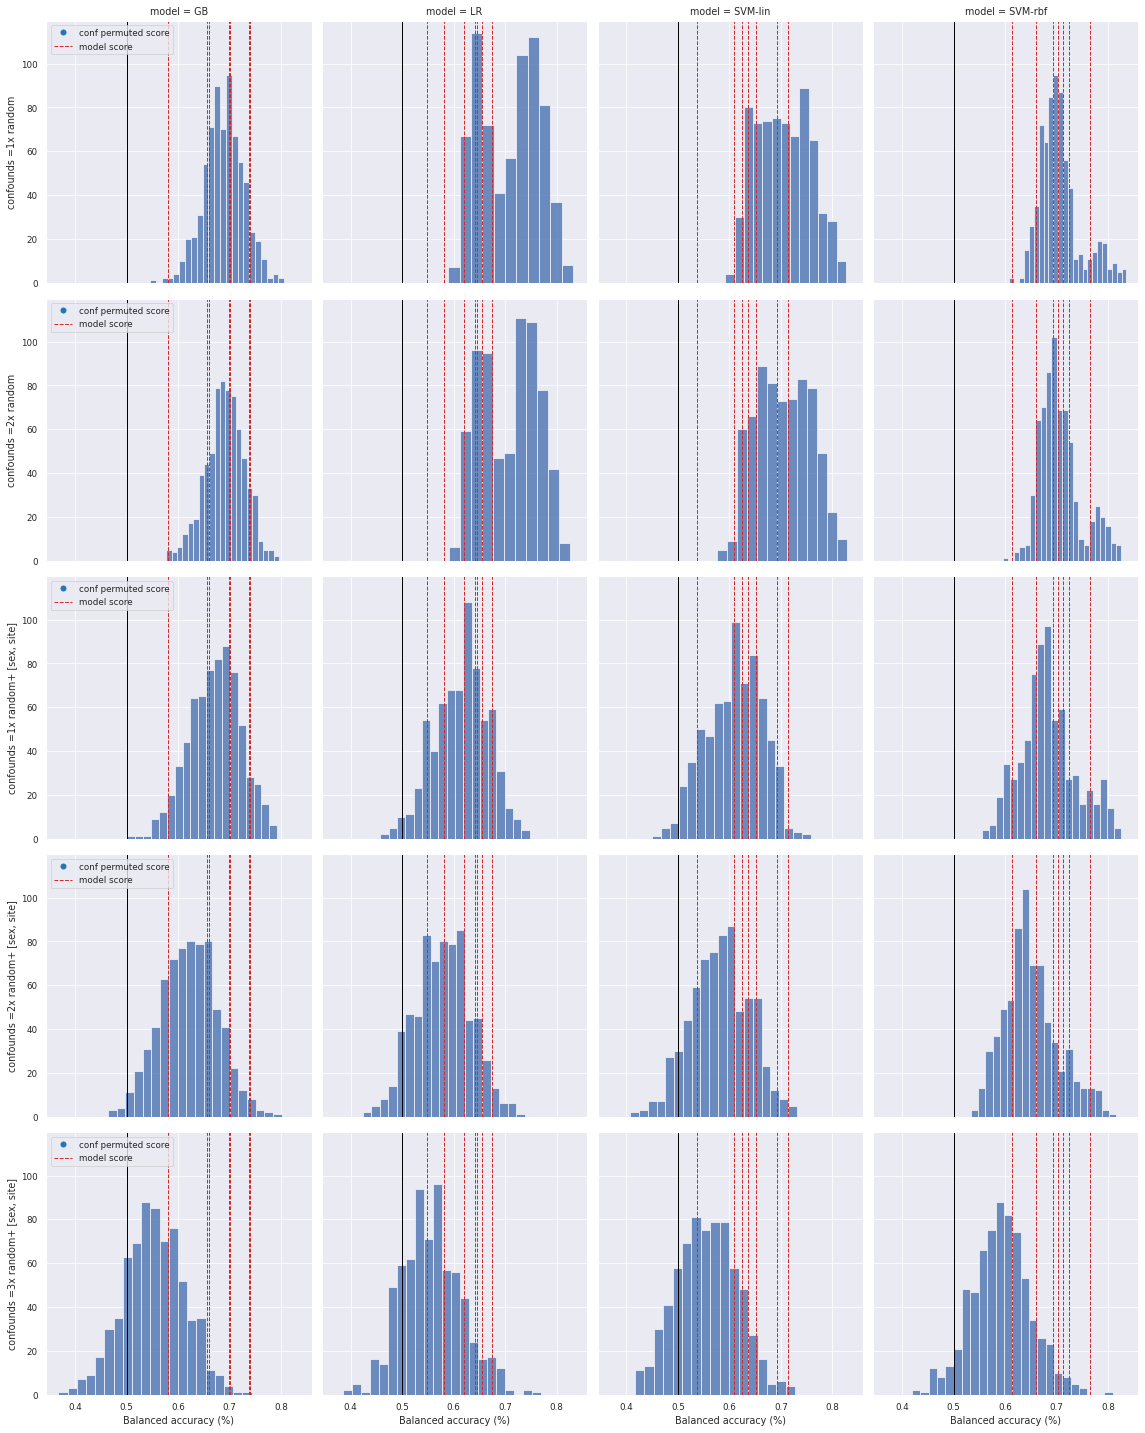

In [60]:
df_true = pd.read_csv("../MLpipelines/results/newlbls-clean-fu3-espad-fu3-19a-binge-n650/20211026-1911/run.csv")
df_ccs = [
    "results/permuteconfs-1x100-fu3-excludingsexsite/*/run.csv",  
    "results/permuteconfs-2x100-fu3-excludingsexsite/*/run.csv",  
    "results/permuteconfs-1x100-fu3/*/run.csv",  
    "results/permuteconfs-2x100-fu3/*/run.csv",  
    "results/permuteconfs-3x100-fu3/*/run.csv",
]


plot_dists(df_ccs, df_true)        
# plt.suptitle(f"Effects of controlling for N random confounds at once:")
plt.tight_layout()
# plt.savefig("Effects of controlling for N random confounds at once")

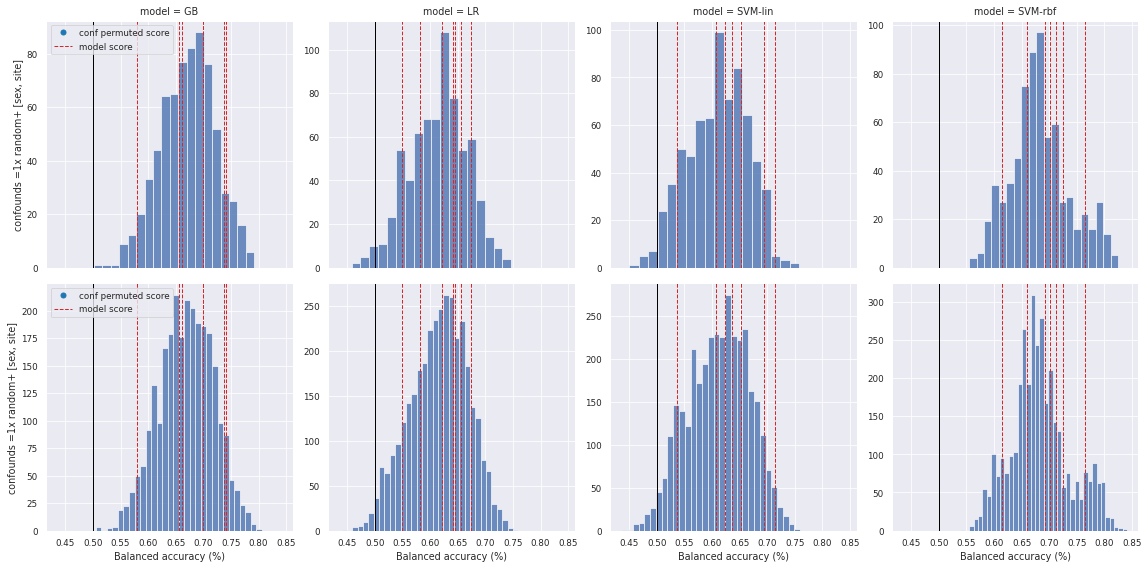

In [10]:
df_ccs = [
    "results/permuteconfs-1x100-fu3/*/run.csv",  
    "results/permuteconfs-1x500-fu3/*/run.csv",  
]


plot_dists(df_ccs, df_true, sharey=False)        
# plt.suptitle(f"Effects of controlling for N random confounds at once:")
plt.tight_layout()
plt.show()

#### Binarizing boundaries

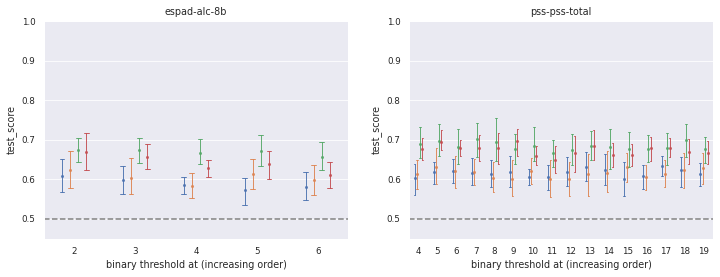

In [24]:
f, axes = plt.subplots(1,2, figsize=(12,4))

for i, bin_exp in enumerate(glob("results/binarizeall-*/*/run.csv")):
    var_name = bin_exp.split('/')[-3].replace("binarizeall-posthoc-cc-fu3-", '').replace('-binarize-all-n650','')
    
    df_bin = pd.read_csv(bin_exp)
    df_bin['confs'] = [int(eval(lst)[-1].replace(var_name,'').replace('t','')) for lst in df_bin['confs']]
    
    # plotting details
    palette = sns.color_palette()
    ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08  
    ML_MODELS = ["LR", "SVM-lin", "SVM-rbf", "GB"]
    hue_order= [m for m in ML_MODELS if m in df_bin.model.unique()]
    if len(hue_order)==0: hue_order=None
        
    sns.pointplot(y='test_score', x='confs', data=df_bin, order=np.sort(df_bin['confs'].unique()), 
                  hue="model", hue_order=hue_order, join=False, 
                  ax=axes[i], 
                  ci=ci, errwidth=errwidth, capsize=capsize,
                  dodge=dodge, scale=scale, palette=palette)
    
    axes[i].set_xlabel('binary threshold at (increasing order)')
    axes[i].set_title(var_name)
    axes[i].axhline(y=0.5, label="chance", c='gray', ls='--', lw=1.5)
    axes[i].set_ylim(0.45,1.0)
    axes[i].get_legend().remove()

plt.savefig("binarizing")